In [191]:
import colour
import colour.utilities
from colour import plotting as cplt
from matplotlib import pyplot as plt
import numpy as np

colour.utilities.suppress_warnings(True)

# Generate Random LEDs

This code generates 5 random LEDs. Three narrow band LEDs and two broad band LEDs. The generator produces "normalized" 0-1 SPDs.

In [ ]:
import colour
import colour.utilities
from colour import plotting as cplt
from matplotlib import pyplot as plt
import numpy as np

colour.utilities.suppress_warnings(True)

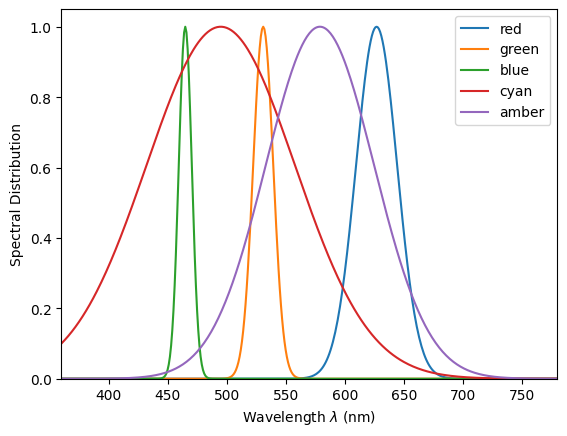

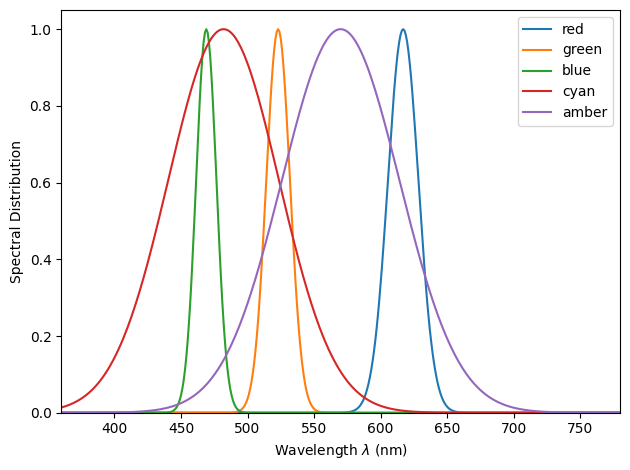

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Wavelength $\\lambda$ (nm)', ylabel='Spectral Distribution'>)

In [192]:

from colour import MultiSpectralDistributions, SpectralDistribution
from colour.colorimetry import sd_gaussian_fwhm

rng = np.random.default_rng()

blue_sd =  sd_gaussian_fwhm(peak_wavelength=rng.integers(460,470), fwhm=rng.integers(12,20), name="blue")
green_sd = sd_gaussian_fwhm(peak_wavelength=rng.integers(520,550), fwhm=rng.integers(20,40), name="green")
red_sd =   sd_gaussian_fwhm(peak_wavelength=rng.integers(600,630), fwhm=rng.integers(25,45), name="red")
cyan_sd =  sd_gaussian_fwhm(peak_wavelength=rng.integers(480,500), fwhm=rng.integers(50,150), name="cyan")
amber_sd = sd_gaussian_fwhm(peak_wavelength=rng.integers(560,590), fwhm=rng.integers(50,150), name="amber")

generated_LEDs = MultiSpectralDistributions([red_sd,green_sd,blue_sd,cyan_sd,amber_sd])
cplt.plot_multi_sds(generated_LEDs)

## Generate a random mixture where each LED has more or less power. 

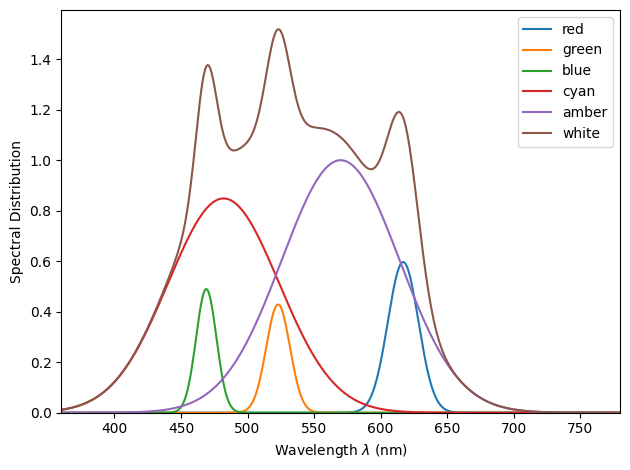

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Wavelength $\\lambda$ (nm)', ylabel='Spectral Distribution'>)

In [193]:
true_ratios = np.concatenate((rng.uniform(low=0.4, high=.6, size=3), rng.uniform(low=.7, high=1.2, size=2)), axis=0)
true_ratios /= np.max(true_ratios)

true_LEDs = generated_LEDs.copy()
true_LEDs.values *= true_ratios
true_white = SpectralDistribution(data=np.sum(true_LEDs.values, axis=1), domain=true_LEDs.domain, name="white")

cplt.plot_multi_sds([true_LEDs, true_white])

## Simulate some measurements

 We add some adding spectral bandwidth error, instrument noise, and user noise. User noise can come from the user not placing their spectral incident meter in in the exact same beam position and orientation. It reccomended to set the instrument in a jig or on a table and as much as possible not move the meter or light between measurements. 

 The noise values used here simulate a Sekonic C-700

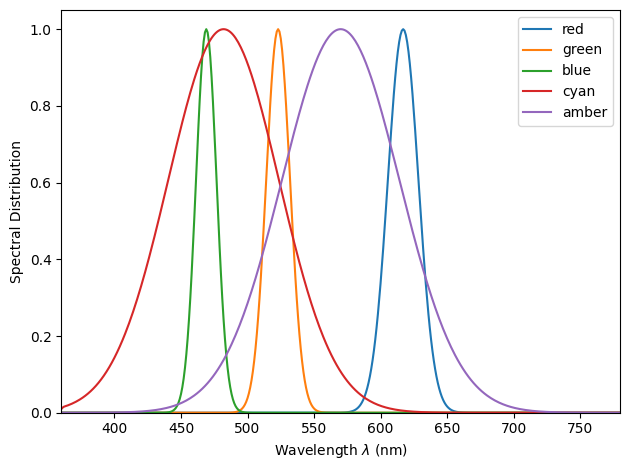

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Wavelength $\\lambda$ (nm)', ylabel='Spectral Distribution'>)

In [194]:
from dataclasses import dataclass

from scipy import signal


@dataclass
class NoiseCharacteristics:
    bandwidth: float
    sensor_resolution: float
    repeatability: float
    operator_repeatability: float

# C700 costs $1200
# Sensor resolution is unknown but save files are reported in 1nm
C700 = NoiseCharacteristics(bandwidth=11,sensor_resolution=1,repeatability=.01,operator_repeatability=0.02)

# CR300 + Calibrated Spectralon Target costs $23,000.
# Repeatability is 1% at 1fl, but much better at high luminance. Estimated based on experience. 
CR300 = NoiseCharacteristics(bandwidth=2,sensor_resolution=1,repeatability=.001,operator_repeatability=0.02)

instrument = CR300
measurements_primaries = generated_LEDs.copy()

bandwidth_characteristic = signal.windows.triang(instrument.bandwidth*2 + 1)
bandwidth_characteristic = bandwidth_characteristic.reshape((bandwidth_characteristic.shape[0], 1))
measurements_primaries.values = signal.convolve(measurements_primaries.values,bandwidth_characteristic,mode="same")

#Make measurements "normalized" where all the indevidual measurements are scaled to a maximum of 1.0
measurements_primaries.values /= np.max(measurements_primaries.values, axis=0)
cplt.plot_multi_sds((measurements_primaries))

# Calculate the measurement of the "true_white" 

Mathematically we apply the measurement noise here. The primary measurements are normalized,
but the measurement noise means that the indevidual components that make of the "white" 
measurement will be +/- the repeatability from primary measurements. 

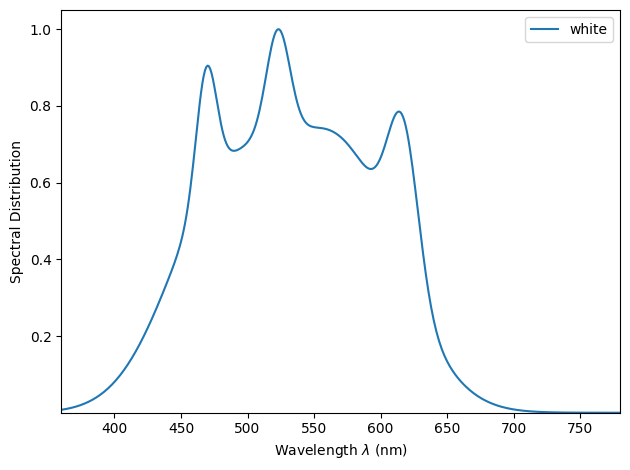

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Wavelength $\\lambda$ (nm)', ylabel='Spectral Distribution'>)

In [195]:
instrument_noise = rng.normal(loc=1, scale=instrument.repeatability, size=true_ratios.shape)
operator_noise = rng.normal(loc=1, scale=instrument.operator_repeatability, size=true_ratios.shape)
noisy_ratios = true_ratios * instrument_noise * operator_noise

measurements_white = SpectralDistribution(data=np.sum(generated_LEDs.values * noisy_ratios, axis=1), domain=true_LEDs.domain, name="white")

# Again, pretend the data from the measurements is normalized.
measurements_white.values /= np.max(measurements_white.values)

cplt.plot_multi_sds(measurements_white)

# Predict the relative brightness of each channel

Based on the normalized measurements of each primary and the "white" mixture where each primary channel is turned to full and measured at the same time. Each indevidual curve is normalized as demonstrated in the first plot cell. 

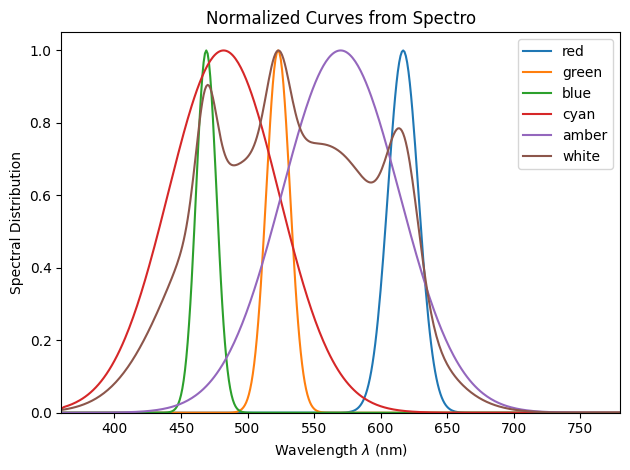

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Normalized Curves from Spectro'}, xlabel='Wavelength $\\lambda$ (nm)', ylabel='Spectral Distribution'>)

In [196]:
cplt.plot_multi_sds([measurements_primaries, measurements_white], title="Normalized Curves from Spectro")

In [197]:
estimated_ratios = np.linalg.pinv(measurements_primaries.values).dot(measurements_white.values)
estimated_ratios /= np.max(estimated_ratios)

error = estimated_ratios - true_ratios
print("true ratios: ")
print(true_ratios)
print("estimated ratios: ")
print(estimated_ratios)
print("error: ")
print(error)


true ratios: 
[ 0.59694642  0.42891088  0.49016628  0.84856558  1.        ]
estimated ratios: 
[ 0.59634725  0.42911376  0.48867004  0.84455906  1.        ]
error: 
[-0.00059917  0.00020287 -0.00149623 -0.00400652  0.        ]
